In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import wilcoxon
from sklearn.linear_model import LinearRegression
import os

Inter the data location :/content/VRU_FAR_10km_1.trial
Columns in dataset: Index(['Name', 'Information', 'Timestamp[ms]', 'Date[MM.dd.yyyy]',
       'Time[hh:mm:ss.fff]', 'Gpstime[ms]', 'GnssStatus', 'Lat[wgs84]',
       'Lng[wgs84]', 'Height[m]', 'Heading[°]', 'Speed[m/s]', 'Speed[km/h]',
       'Acceleration[m/s²]', 'North[m]', 'East[m]', 'Name.1', 'Information.1',
       'Timestamp[ms].1', 'Date[MM.dd.yyyy].1', 'Time[hh:mm:ss.fff].1',
       'Gpstime[ms].1', 'GnssStatus.1', 'Lat[wgs84].1', 'Lng[wgs84].1',
       'Height[m].1', 'Heading[°].1', 'Speed[m/s].1', 'Speed[km/h].1',
       'Acceleration[m/s²].1', 'North[m].1', 'East[m].1', 'Distance[m]',
       'YawRate[deg/s]', 'vX[m/s]', 'vY[m/s]', 'Lateral Distance[m]',
       'Forward Distance[m]', 'GeoDistance[m]', 'DistanceFromOrigin[m]',
       'Name.2', 'Information.2', 'Timestamp[ms].2', 'Date[MM.dd.yyyy].2',
       'Time[hh:mm:ss.fff].2', 'Gpstime[ms].2', 'GnssStatus.2', 'Lat[wgs84].2',
       'Lng[wgs84].2', 'Height[m].2', 'Headi

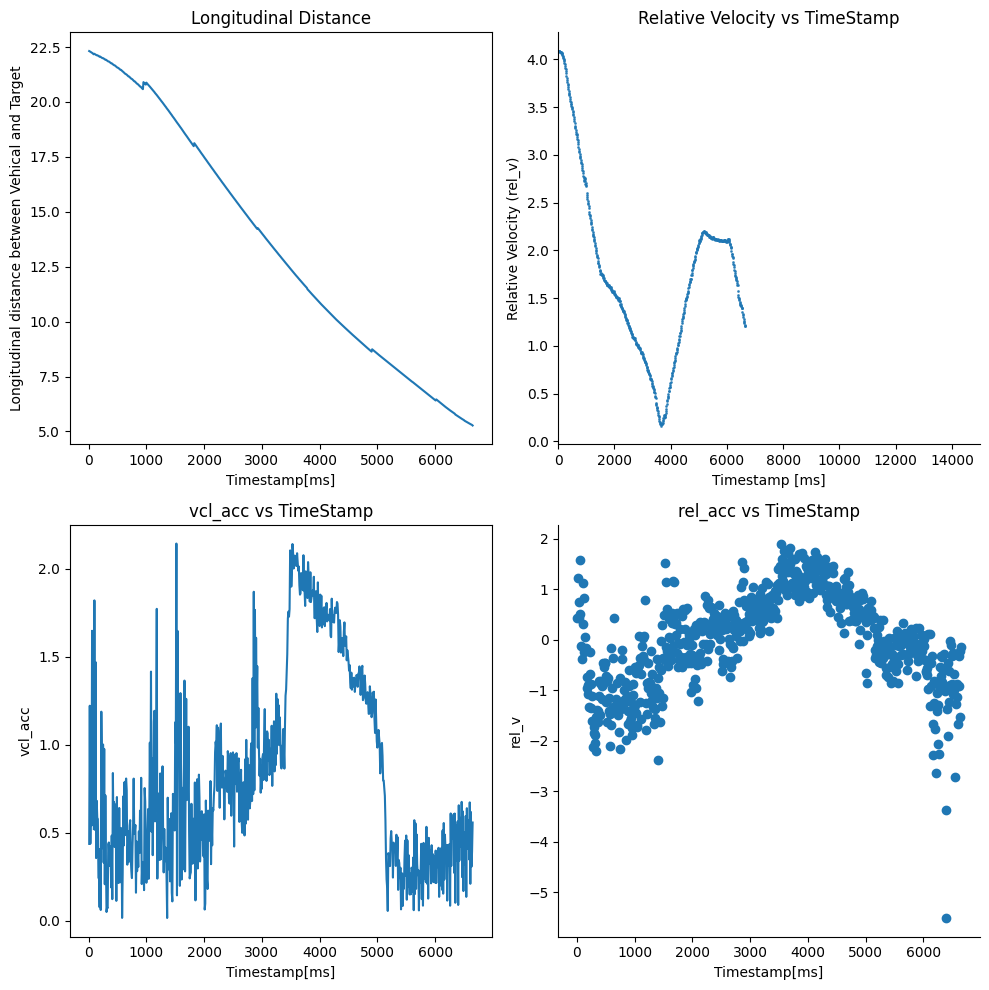

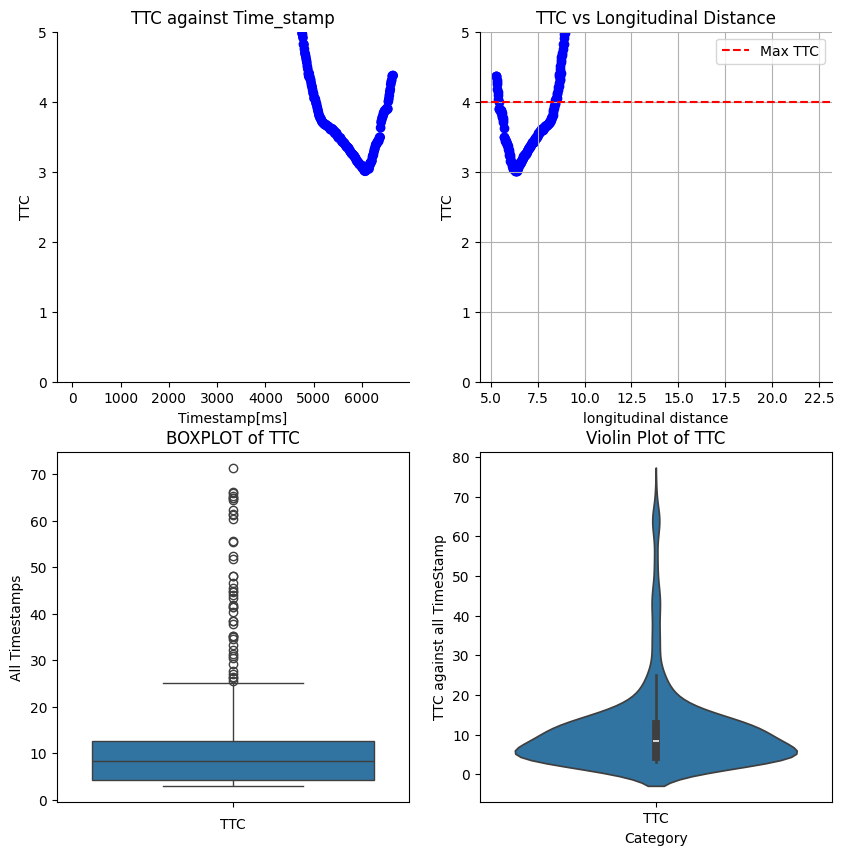

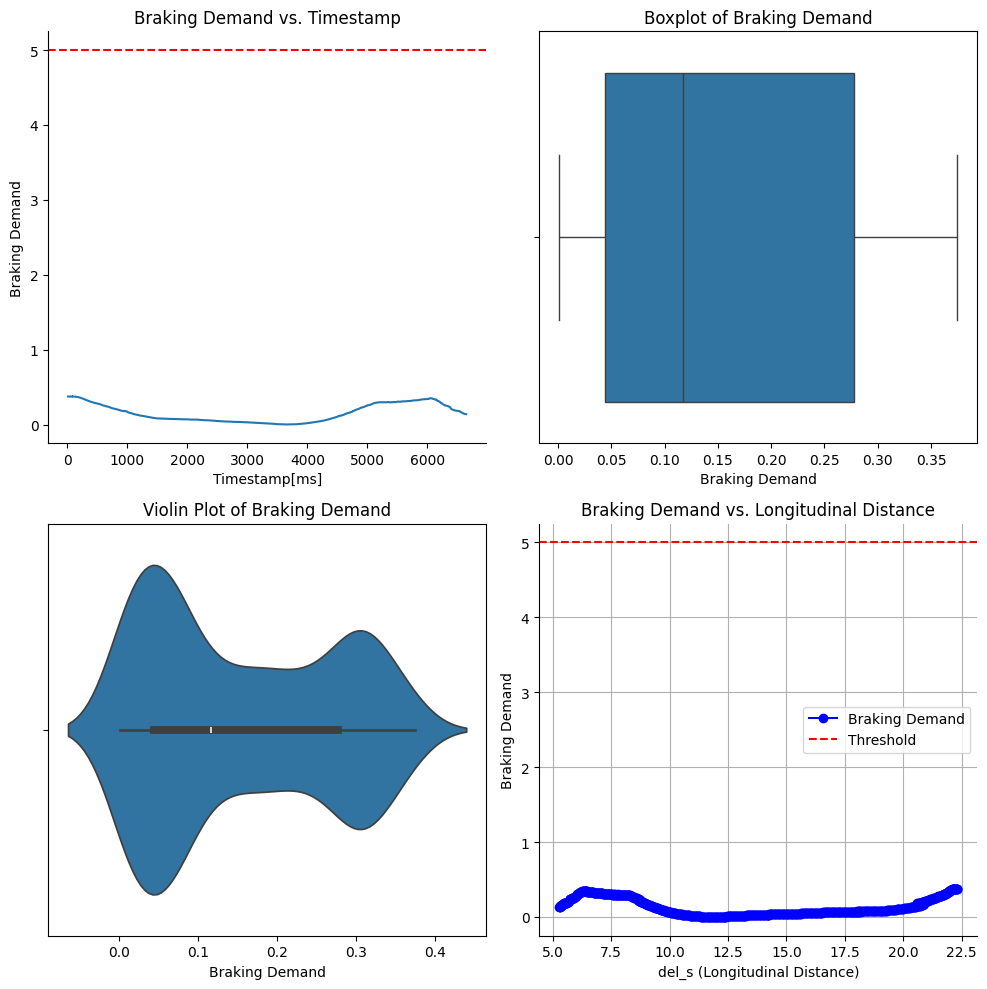

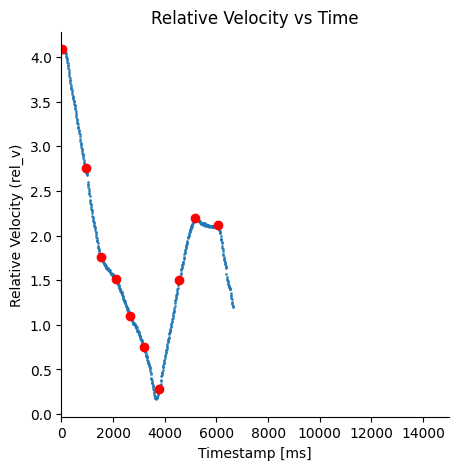

Peak Index | Peak Value | Peak Timestamp
----------------------------------------
2 | 4.086131466465179 | 30
94 | 2.759067369786932 | 950
152 | 1.7596148647595244 | 1530
209 | 1.5114363790725154 | 2100
264 | 1.09539185679033 | 2650
317 | 0.748018714935757 | 3180
376 | 0.27894233004161845 | 3770
454 | 1.4977121575438266 | 4550
516 | 2.1986058886934923 | 5170
604 | 2.11884195817263 | 6050


In [ ]:
class vru_test:
    def __init__(self, dataset):
      if isinstance(dataset, str):
          try:
              self.df = pd.read_csv(
                  dataset,
                  delimiter=';',
                  header=122,
                  on_bad_lines='skip'
              )
              # Strip any extra spaces in column names for consistency
              self.df.columns = self.df.columns.str.strip()
              print("Columns in dataset:", self.df.columns)  # Print available columns for debugging
          except FileNotFoundError:
              raise Exception(f"File not found: {dataset}")
      elif isinstance(dataset, pd.DataFrame):  # Check if dataset is a DataFrame
            self.df = dataset.copy()  # Use the provided DataFrame directly
            print("Using provided DataFrame.")
      else:
          raise TypeError("Invalid dataset type. Expected str (file path) or pd.DataFrame.")

      # Ensure all required columns are present in the dataset
      self.validate_columns()

      # Process the dataset to compute new attributes
      self.process_dataset()
      self.all_plot()
      self.ttc_plot()
      self.bd_plot()
      self.find_peak()


      # The function definations start here ------------------------------------------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

    def validate_columns(self):
        """
        Validate that all required columns are present in the dataset.
        If any required columns are missing, raise a KeyError.
        """
        required_columns = [
            'Lat[wgs84].1', 'Lng[wgs84].1', 'vX[m/s]', 'vY[m/s]',
            'Acceleration[m/s²].1', 'Lat[wgs84].2', 'Lng[wgs84].2',
            'vX[m/s].1', 'vY[m/s].1', 'Acceleration[m/s²].2', 'Timestamp[ms]'
        ]

        # Identify missing columns
        missing_columns = [col for col in required_columns if col not in self.df.columns]
        if missing_columns:
            raise KeyError(f"Missing columns in dataset: {missing_columns}")

    def longitude_to_meters(self, longitudes, latitudes):
        """
        Convert longitude values to distances in meters based on latitude.
        This accounts for Earth's curvature.
        """
        latitudes_radians = np.radians(latitudes)  # Convert latitude to radians
        return longitudes * 111320 * np.cos(latitudes_radians)  # Convert to meters

    def process_dataset(self):
        """
        Process the dataset to calculate new attributes such as:
        - Longitudinal distance
        - Relative velocity
        - Relative acceleration
        """
        # Extract pedestrian coordinates
        self.ped_lat = self.df['Lat[wgs84].1']  # Pedestrian latitude
        self.ped_lng = self.df['Lng[wgs84].1']  # Pedestrian longitude

        # Extract pedestrian velocities
        self.ped_vel_x = self.df['vX[m/s]']  # Pedestrian velocity in x-direction
        self.ped_vel_y = self.df['vY[m/s]']  # Pedestrian velocity in y-direction

        # Extract pedestrian acceleration
        self.ped_acc = self.df['Acceleration[m/s²].1']  # Pedestrian acceleration

        # Extract vehicle coordinates
        self.vcl_lat = self.df['Lat[wgs84].2']  # Vehicle latitude
        self.vcl_lng = self.df['Lng[wgs84].2']  # Vehicle longitude

        # Extract vehicle velocities
        self.vcl_vel_x = self.df['vX[m/s].1']  # Vehicle velocity in x-direction
        self.vcl_vel_y = self.df['vY[m/s].1']  # Vehicle velocity in y-direction

        # Extract vehicle acceleration
        self.vcl_acc = self.df['Acceleration[m/s²].2']  # Vehicle acceleration

        # Convert vehicle and pedestrian longitudes to distances in meters
        self.vcl_lng_m = self.longitude_to_meters(self.vcl_lng, self.vcl_lat)
        self.ped_lng_m = self.longitude_to_meters(self.ped_lng, self.ped_lat)

        # Compute the longitudinal distance between the vehicle and pedestrian
        self.df['del_s'] = self.vcl_lng_m - self.ped_lng_m

        # Compute the resultant velocity for both the vehicle and pedestrian
        self.df['rel_v'] = np.sqrt(
            (self.vcl_vel_x - self.ped_vel_x)**2 +
            (self.vcl_vel_y - self.ped_vel_y)**2
        )

        # Compute the relative acceleration between the vehicle and pedestrian
        self.df['rel_acc'] = self.vcl_acc - self.ped_acc
        return self.df['rel_v']



    def vel_plot(self):
        """
        Plot the relative velocity (`rel_v`) over time (`Timestamp[ms]`).
        This visualizes the changes in relative velocity between the vehicle and pedestrian.
        """
        plt.figure(figsize=(5,5))  # Set plot size
        plt.scatter(x=self.df['Timestamp[ms]'], y=self.df['rel_v'], s=1, alpha=0.8)
        plt.xlim(0, 15000)  # Set x-axis limits
        plt.gca().spines[['top', 'right']].set_visible(False)  # Hide top and right spines
        plt.xlabel('Timestamp [ms]')  # Label x-axis
        plt.ylabel('Relative Velocity (rel_v)')  # Label y-axis
        plt.title('Relative Velocity vs Time')  # Add plot title
        # plt.show()

    def s_plot(self):
        self.df.plot(x='Timestamp[ms]',y='del_s')
        plt.xlabel('Timestamp[ms]')
        plt.ylabel('Longitudinal distance between Vehical and Target')
        # plt.gca().spines[['top', 'right',]].set_visible(False)
        plt.title('Longitudinal distance between Vehical and Target')


    def vcl_acc_plot(self):
      x=self.df['Timestamp[ms]']
      y=self.vcl_acc
      plt.plot(x,y)
      plt.xlabel('Timestamp[ms]')
      plt.ylabel('vcl_acc')
      # plt.show()
      # plt.gca().spines[['top', 'right',]].set_visible(False)





    def all_plot(self,save_path="/content/plots"):
        fig , axes = plt.subplots(2,2,figsize=(10,10))
        os.makedirs(save_path, exist_ok=True)

        plt.sca(axes[0,0])
        plt.plot(self.df['Timestamp[ms]'],self.df['del_s'])
        plt.xlabel('Timestamp[ms]')
        plt.ylabel('Longitudinal distance between Vehical and Target')
        # plt.gca().spines[['top', 'right',]].set_visible(False)
        axes[0,0].set_title('Longitudinal Distance')

        plt.sca(axes[0,1])
        plt.scatter(x=self.df['Timestamp[ms]'], y=self.df['rel_v'], s=1, alpha=0.8)
        plt.xlim(0, 15000)  # Set x-axis limits
        plt.gca().spines[['top', 'right']].set_visible(False)  # Hide top and right spines
        plt.xlabel('Timestamp [ms]')  # Label x-axis
        plt.ylabel('Relative Velocity (rel_v)')  # Label y-axis
        axes[0,1].set_title('Relative Velocity vs TimeStamp')

        plt.sca(axes[1,0])
        self.vcl_acc_plot()
        axes[1,0].set_title('vcl_acc vs TimeStamp')

        plt.sca(  axes[1,1])
        plt.scatter(self.df['Timestamp[ms]'],self.df['rel_acc'])
        plt.xlabel('Timestamp[ms]')
        plt.ylabel('rel_v')
        axes[1,1].set_title('rel_acc vs TimeStamp')
        plt.gca().spines[['top', 'right']].set_visible(False)
        # plt.xlim(0,10000)

        plt.tight_layout()
        plt.savefig(os.path.join(save_path, "all_plots.png"))
        plt.show()


    def poly_reg(self):
      x = self.df['Timestamp[ms]'].values.reshape(-1, 1)
      y = self.df['rel_acc'].values
      degree =2
      mask = np.isnan(y)
      y=y[~mask]
      x=x[~mask]
      poly_features = PolynomialFeatures(degree=degree)
      x_poly = poly_features.fit_transform(x)
      model = LinearRegression()
      model.fit(x_poly, y)

      x_reg = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
      x_reg_poly = poly_features.transform(x_reg)
      y_reg = model.predict(x_reg_poly)


      plt.scatter(x, y, s=5, alpha=.8)
      plt.plot(x_reg, y_reg, color='red')
      # plt.xlim(0, 10000)
      plt.gca().spines[['top', 'right']].set_visible(False)
      plt.xlabel('Timestamp[ms]')
      plt.ylabel('rel_acc')
      plt.show()

    # TTC CALCULATION----------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>------------------>>>>>>>>>>>>>>>>>


    def ttc_s_plot(self,ttc):
        plt.scatter(self.df['del_s'],ttc,c='b')
        plt.xlabel('longitudinal distance')
        plt.ylabel('TTC')
        plt.ylim(0,5)
        plt.axhline(y=4,color='r',linestyle='--',label='Max TTC')
        plt.title('TTC vs. Longitudinal Distance')
        plt.grid(True)
        plt.legend()
        plt.gca().spines[['top', 'right',]].set_visible(False)
        # plt.show()

    def ttc_t_plot(self,ttc):
      # TTC calculation
      # Scatter plot to figure out the outliers
      from scipy.stats import zscore

      # Calculate z-scores for 'Timestamp[ms]'
      z_scores_x = zscore(self.df['Timestamp[ms]'])

      # Filter out NaN values from 'ttc' before calculating z-scores
      valid_ttc_indices = ~np.isnan(self.ttc)
      z_scores_y = zscore(self.ttc[valid_ttc_indices])

      # Align z_scores_x with valid_ttc_indices
      z_scores_x = z_scores_x[valid_ttc_indices]

      threshold = 2

      # Perform the logical OR operation on the aligned arrays
      outliers = (np.abs(z_scores_x) > threshold) | (np.abs(z_scores_y) > threshold)

      colors = ['red' if outlier else 'blue' for outlier in outliers]  # No need to flatten
      plt.scatter(self.df['Timestamp[ms]'][valid_ttc_indices], self.ttc[valid_ttc_indices], c=colors)
      # plt.xlim(0,10000)
      plt.ylim(0,5)
      plt.xlabel('Timestamp[ms]')
      plt.ylabel('TTC')
      plt.gca().spines[['top', 'right']].set_visible(False)
      # plt.show()


    def ttc_vplot(self,ttc):
      # Create a dummy category for the violin plot (if needed)
      # This allows you to make a single violin plot if you don't have any category in the dataset.
      self.df['Category'] = 'TTC'

      # Create the violin plot
      sns.violinplot(x='Category', y=ttc, data=self.df)
      plt.title('Violin Plot of TTC')



    def b_plot(self,ttc):
      sns.boxplot(self.ttc)
      plt.ylabel('All Timestamps')
      plt.xlabel('TTC')
      # plt.show()


    def ttc_calc(self):
      #initialization of the ttc vector with 0s
      self.ttc = np.zeros_like(self.df['rel_v'])

      #ttc calculation formula
      self.ttc = self.df['del_s'] / self.df['rel_v']

      # print(f"Total number of null values in TTC array :{np.isnan(self.ttc).sum()}")
      # ttc.dropna(inplace=True)

      return self.ttc

    def ttc_plot(self,save_path="/content/plots"):
        self.ttc_calc()
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))
        os.makedirs(save_path, exist_ok=True)

        plt.sca(axes[0,0])
        self.ttc_t_plot(self.ttc)
        axes[0,0].set_title("TTC against Time_stamp")


        plt.sca(axes[0,1])
        self.ttc_s_plot(self.ttc)
        axes[0,1].set_title("TTC vs Longitudinal Distance")

        plt.sca(axes[1,0])
        self.b_plot(self.ttc)
        # plt.xlabel('TTC')
        # plt.ylabel('TTC')
        axes[1,0].set_title("BOXPLOT of TTC")

        plt.sca(axes[1,1])
        self.ttc_vplot(self.ttc)
        axes[1,1].set_ylabel("TTC against all TimeStamp")
        plt.savefig(os.path.join(save_path, "TTC_plots.png"))

        # Adjust layout
        # plt.tight_layout()
        plt.show()

#  Braking demand calculation----------------------------------------------->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

    def bd(self):
      self.bd = (self.df['rel_v'])**2 / (2 * self.df['del_s'])
      # self.bd = self.bd[:len(self.df['Timestamp[ms]'])]
      return self.bd



    # def bd_plot(self):
    #   # self.bd()
    #   self.bd = self.bd[:len(self.df['Timestamp[ms]'])]  # Truncate bd to match the length of df['Timestamp[ms]']
    #   fig, axes = plt.subplots(2, 2, figsize=(10, 10))

    #   plt.sca(axes[0,0])
    #   plt.plot(self.df['Timestamp[ms]'], self.bd)
    #   plt.xlabel('Timestamp[ms]')
    #   plt.ylabel('Breaking Demand')
    #   plt.title('Breaking Demand vs. Timestamp')
    #   plt.gca().spines[['top', 'right']].set_visible(False)  # Optional: Removes top and right borders
    #   axes[0,0].set_title("Braking demand vs TimeStamp")

    #   plt.sca(axes[0,1])
    #   sns.boxplot(x=self.bd)
    #   plt.xlabel('All timestamp')
    #   axes[0,1].set_title('Boxplot of Braking Demand')

    #   plt.sca(axes[1,0])
    #   sns.violinplot(x=self.bd)
    #   axes[1,0].set_title('Violin Plot of Braking Demand')

    #   plt.sca(axes[1,1])
    #   plt.plot(self.df['del_s'], self.bd, marker='o', linestyle='-', color='b')
    #   plt.xlabel('del_s (Longitudinal Distance)')
    #   plt.ylabel('Breaking Demand (bd)')
    #   plt.title('Breaking Demand vs. Longitudinal Distance')
    #   plt.grid(True)
    #   Written originally by sidm5387[at]gmail.com
        #   plt.gca().spines[['top', 'right']].set_visible(False)
    #   plt.axhline(y=5, color='r', linestyle='--',label='Threshold')
    #   # plt.axvline(x=8, color='green', linestyle='--',label='full breaking')
    #   axes[1,1].set_title("Braking demand vs Longitudinal Distance")
    #   plt.legend()

    #   plt.show()


    def bd_plot(self,save_path="/content/plots"):
      # Ensure bd length matches Timestamp[ms]
      self.brd = (self.df['rel_v'])**2 / (2 * self.df['del_s'])
      self.brd = self.brd[:len(self.df['Timestamp[ms]'])]

      fig, axes = plt.subplots(2, 2, figsize=(10, 10))

      # Plot 1: Braking Demand vs. Timestamp
      axes[0, 0].plot(self.df['Timestamp[ms]'], self.brd)
      axes[0,0].axhline(y=5, color='r', linestyle='--', label='Threshold')
      axes[0, 0].set_xlabel('Timestamp[ms]')
      axes[0, 0].set_ylabel('Braking Demand')
      axes[0, 0].set_title("Braking Demand vs. Timestamp")
      axes[0, 0].spines[['top', 'right']].set_visible(False)

      # Plot 2: Boxplot of Braking Demand
      sns.boxplot(x=self.brd, ax=axes[0, 1])
      axes[0, 1].set_xlabel('Braking Demand')
      axes[0, 1].set_title('Boxplot of Braking Demand')

      # Plot 3: Violin Plot of Braking Demand
      sns.violinplot(x=self.brd, ax=axes[1, 0])
      axes[1, 0].set_title('Violin Plot of Braking Demand')
      axes[1, 0].set_xlabel('Braking Demand')

      # Plot 4: Braking Demand vs. Longitudinal Distance
      axes[1, 1].plot(self.df['del_s'], self.brd, marker='o', linestyle='-', color='b', label='Braking Demand')
      axes[1, 1].axhline(y=5, color='r', linestyle='--', label='Threshold')
      axes[1, 1].set_xlabel('del_s (Longitudinal Distance)')
      axes[1, 1].set_ylabel('Braking Demand')
      axes[1, 1].set_title("Braking Demand vs. Longitudinal Distance")
      axes[1, 1].spines[['top', 'right']].set_visible(False)
      axes[1, 1].grid(True)
      axes[1, 1].legend()

      # Show the plots
      plt.tight_layout()
      plt.savefig(os.path.join(save_path, "breaking_demand_plots.png"))
      plt.show()


    def to_csv(self,filename):
      self.df.to_csv(f'{filename}.csv', index=True)
      print(f"DataFrame saved to {filename}")

    def find_peak(self,save_path="/content/plots"):
      from scipy.signal import find_peaks
      x=self.df['rel_v'].values
      peaks, _ = find_peaks(x, height=0,distance=50,prominence=None)
      self.vel_plot()
      plt.scatter(self.df['Timestamp[ms]'].iloc[peaks], x[peaks], color='red')
      plt.savefig(os.path.join(save_path, "peaks_plots.png"))
      plt.show()
      print("Peak Index | Peak Value | Peak Timestamp")
      print("-" * 40)
      for idnx ,values , time_stamp in zip(peaks,x[peaks],self.df['Timestamp[ms]'].iloc[peaks]):
        print(f"{idnx} | {values} | {time_stamp}")




if __name__ == "__main__":
  data = input("Inter the data location :")
  df1 = vru_test(data)


Columns in dataset: Index(['Name', 'Information', 'Timestamp[ms]', 'Date[MM.dd.yyyy]',
       'Time[hh:mm:ss.fff]', 'Gpstime[ms]', 'GnssStatus', 'Lat[wgs84]',
       'Lng[wgs84]', 'Height[m]', 'Heading[°]', 'Speed[m/s]', 'Speed[km/h]',
       'Acceleration[m/s²]', 'North[m]', 'East[m]', 'Name.1', 'Information.1',
       'Timestamp[ms].1', 'Date[MM.dd.yyyy].1', 'Time[hh:mm:ss.fff].1',
       'Gpstime[ms].1', 'GnssStatus.1', 'Lat[wgs84].1', 'Lng[wgs84].1',
       'Height[m].1', 'Heading[°].1', 'Speed[m/s].1', 'Speed[km/h].1',
       'Acceleration[m/s²].1', 'North[m].1', 'East[m].1', 'Distance[m]',
       'YawRate[deg/s]', 'vX[m/s]', 'vY[m/s]', 'Lateral Distance[m]',
       'Forward Distance[m]', 'GeoDistance[m]', 'DistanceFromOrigin[m]',
       'Name.2', 'Information.2', 'Timestamp[ms].2', 'Date[MM.dd.yyyy].2',
       'Time[hh:mm:ss.fff].2', 'Gpstime[ms].2', 'GnssStatus.2', 'Lat[wgs84].2',
       'Lng[wgs84].2', 'Height[m].2', 'Heading[°].2', 'Speed[m/s].2',
       'Speed[km/h].2', 'Acce

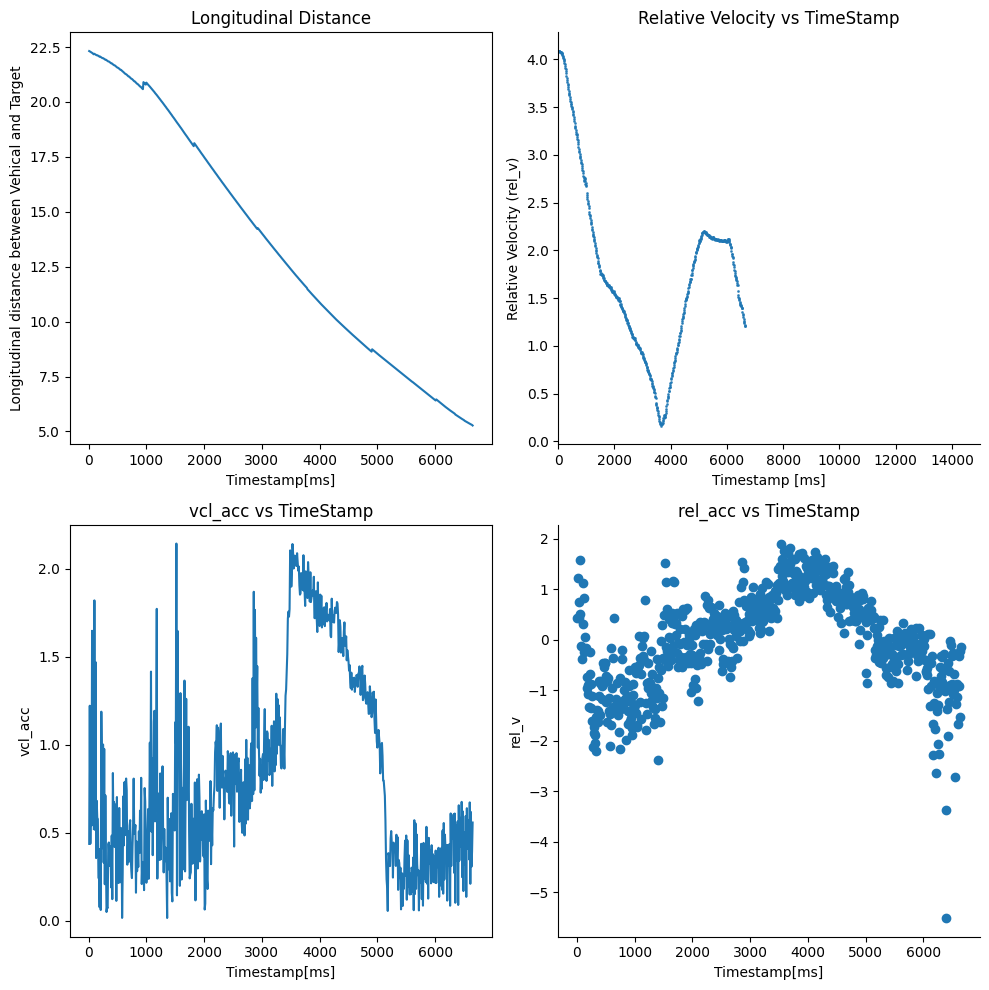

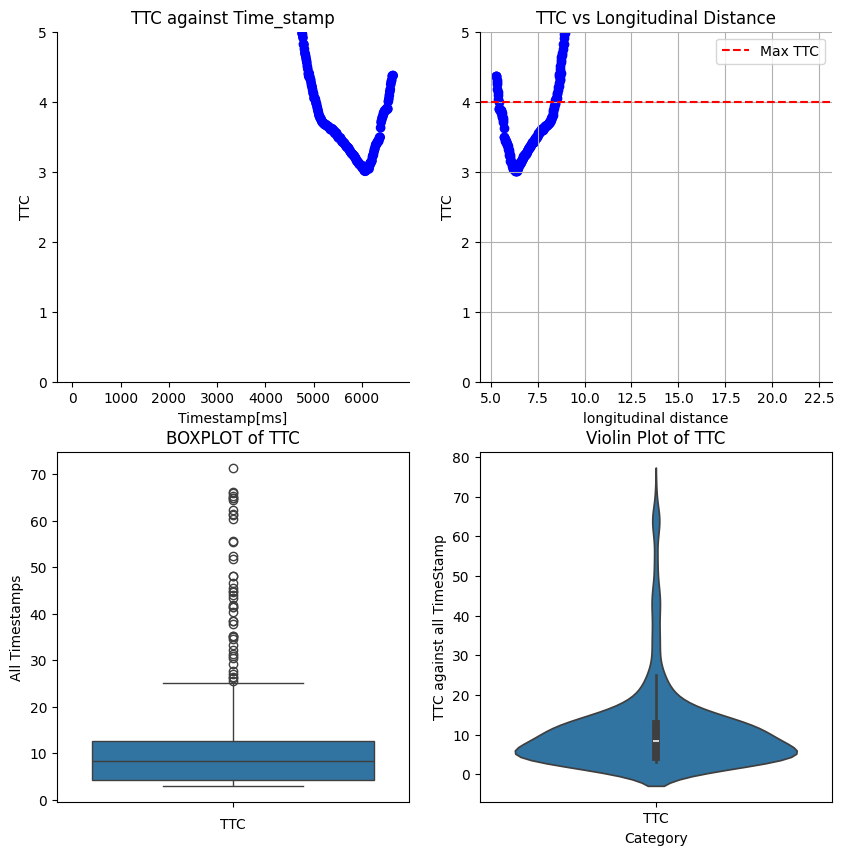

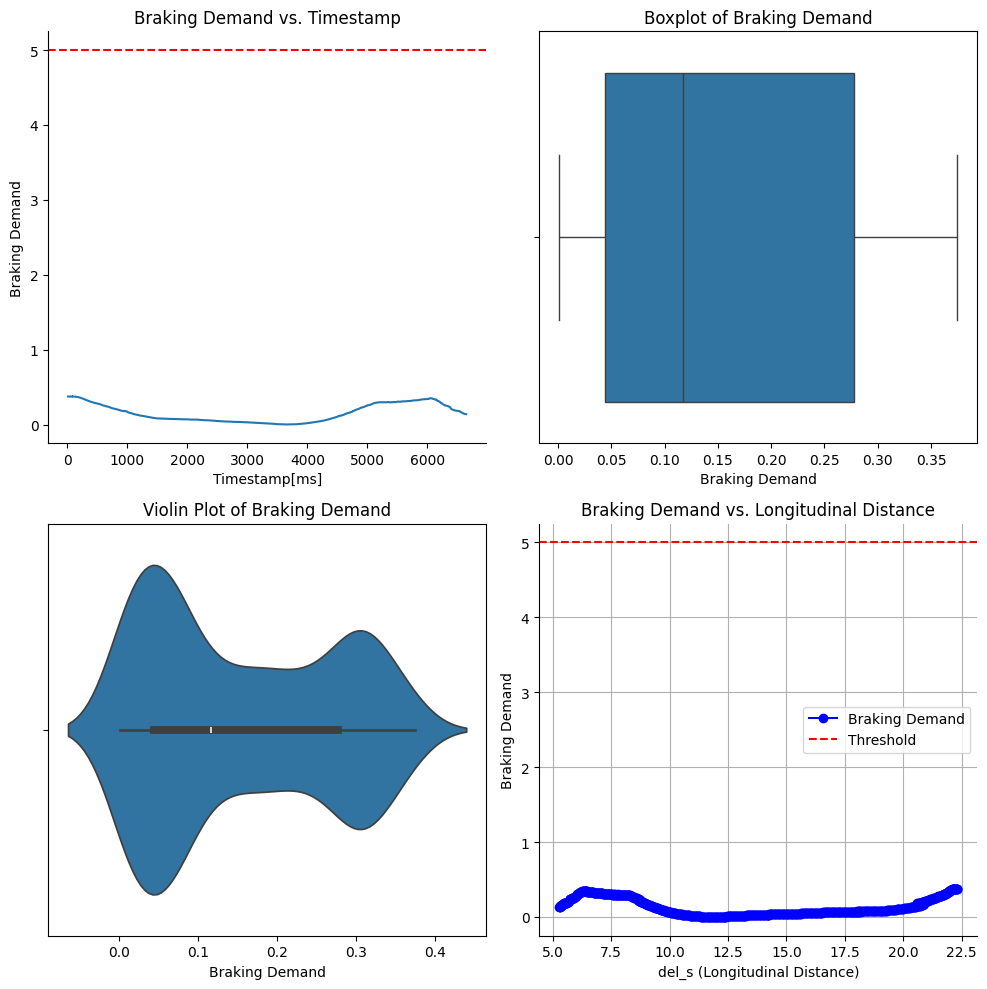

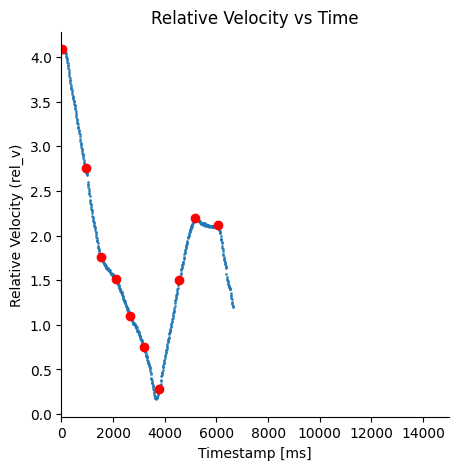

Peak Index | Peak Value | Peak Timestamp
----------------------------------------
2 | 4.086131466465179 | 30
94 | 2.759067369786932 | 950
152 | 1.7596148647595244 | 1530
209 | 1.5114363790725154 | 2100
264 | 1.09539185679033 | 2650
317 | 0.748018714935757 | 3180
376 | 0.27894233004161845 | 3770
454 | 1.4977121575438266 | 4550
516 | 2.1986058886934923 | 5170
604 | 2.11884195817263 | 6050


In [ ]:
df1 = vru_test("/content/VRU_FAR_10km_1.trial")

# **Trial 1**


In [ ]:
from scipy.stats import wilcoxon
''' Wilcoxon Test for non parametric dataset'''

datasets = ttc_all

standard_ttc = 4

for i, dataset in enumerate(datasets):

    valid_data = dataset[~np.isnan(dataset)]

    # Create a hypothetical dataset representing the standard TTC
    standard_ttc_values = np.full(len(valid_data), standard_ttc)


    statistic, p_value = wilcoxon(valid_data, standard_ttc_values)

    print(f"Dataset {i+1}:")
    print(f"  The median TTC of dataset: {np.median(dataset.dropna())}")
    print(f"  Wilcoxon Statistic: {statistic}")
    print(f"  P-value: {p_value}")

    alpha = 0.05  # Significance level
    if p_value < alpha:
        print("  Reject the null hypothesis. The distribution of TTC values is significantly different from the standard TTC of 4 seconds.")
    else:
        print("  Fail to reject the null hypothesis. There's not enough evidence to say the distributions of TTC values are different from the standard TTC of 4 seconds.")
    print("-" * 20)

NameError: name 'ttc_all' is not defined

A Wilcoxon test statistic of 0 typically occurs when all differences between the observed values and the standard are in the same direction

# Like in our case all the values of TTC are smaller than the standard of 4 Seconds.

In [ ]:
from scipy.stats import wilcoxon

''' Wilcoxon Test for non parametric dataset'''

datasets = bd_all

standard_bd = 5

for i, dataset in enumerate(datasets):

    valid_data = pd.to_numeric(dataset, errors='coerce')
    valid_data = valid_data[~np.isnan(valid_data)]

    # Create a hypothetical dataset representing the standard TTC
    standard_bd_values = np.full(len(valid_data), standard_bd)

    # Perform the Wilcoxon Signed-Rank Test
    statistic, p_value = wilcoxon(valid_data, standard_bd_values)

    print(f"Dataset {i+1}:")
    print(f"  The median breaking demand of dataset: {np.median(dataset.dropna())}")
    print(f"  Wilcoxon Statistic: {statistic}")
    print(f"  P-value: {p_value}")

    alpha = 0.05  # Significance level
    if p_value < alpha:
        print("  Reject the null hypothesis. The distribution of BD values is significantly different from the standard Braking Demand of 5m/s^2.")
    else:
        print("  Fail to reject the null hypothesis. There's not enough evidence to say the distributions of BD values are different from the standard Breaking Demand of 5m/s^2 seconds.")
    print("-" * 20)

Dataset 1:
  The median breaking demand of dataset: 0.11741785323582776
  Wilcoxon Statistic: 0.0
  P-value: 2.1458533066401484e-110
  Reject the null hypothesis. The distribution of BD values is significantly different from the standard Braking Demand of 5m/s^2.
--------------------
Dataset 2:
  The median breaking demand of dataset: 0.11741785323582776
  Wilcoxon Statistic: 0.0
  P-value: 2.1458533066401484e-110
  Reject the null hypothesis. The distribution of BD values is significantly different from the standard Braking Demand of 5m/s^2.
--------------------
Dataset 3:
  The median breaking demand of dataset: 0.11741785323582776
  Wilcoxon Statistic: 0.0
  P-value: 2.1458533066401484e-110
  Reject the null hypothesis. The distribution of BD values is significantly different from the standard Braking Demand of 5m/s^2.
--------------------
Dataset 4:
  The median breaking demand of dataset: 0.11741785323582776
  Wilcoxon Statistic: 0.0
  P-value: 2.1458533066401484e-110
  Reject the

In [ ]:
# df1.to_csv("/content/VRU_FAR_10km_1")
# df2.to_csv("/content/VRU_FAR_10km_2")
# df3.to_csv("/content/VRU_FAR_10km_3")
# df4.to_csv("/content/VRU_FAR_15km_1")
# df5.to_csv("/content/VRU_FAR_15km_2")
# df6.to_csv("/content/VRU_FAR_15km_3")
# df7.to_csv("/content/VRU_FAR_15km_4")
# df8.to_csv("/content/VRU_FAR_15km_5")
# df9.to_csv("/content/VRU_FAR_15km_6")
# df10.to_csv("/content/VRU_FAR_20km_1")
# df11.to_csv("/content/VRU_FAR_20km_2")
# df12.to_csv("/content/VRU_FAR_20km_3")
# df13.to_csv("/content/VRU_FAR_25km_1")
# df14.to_csv("/content/VRU_FAR_25km_2")
# df15.to_csv("/content/VRU_FAR_25km_3")
# # df16.to_csv("/content/VRU_NEAR_10km_30_4.trial")

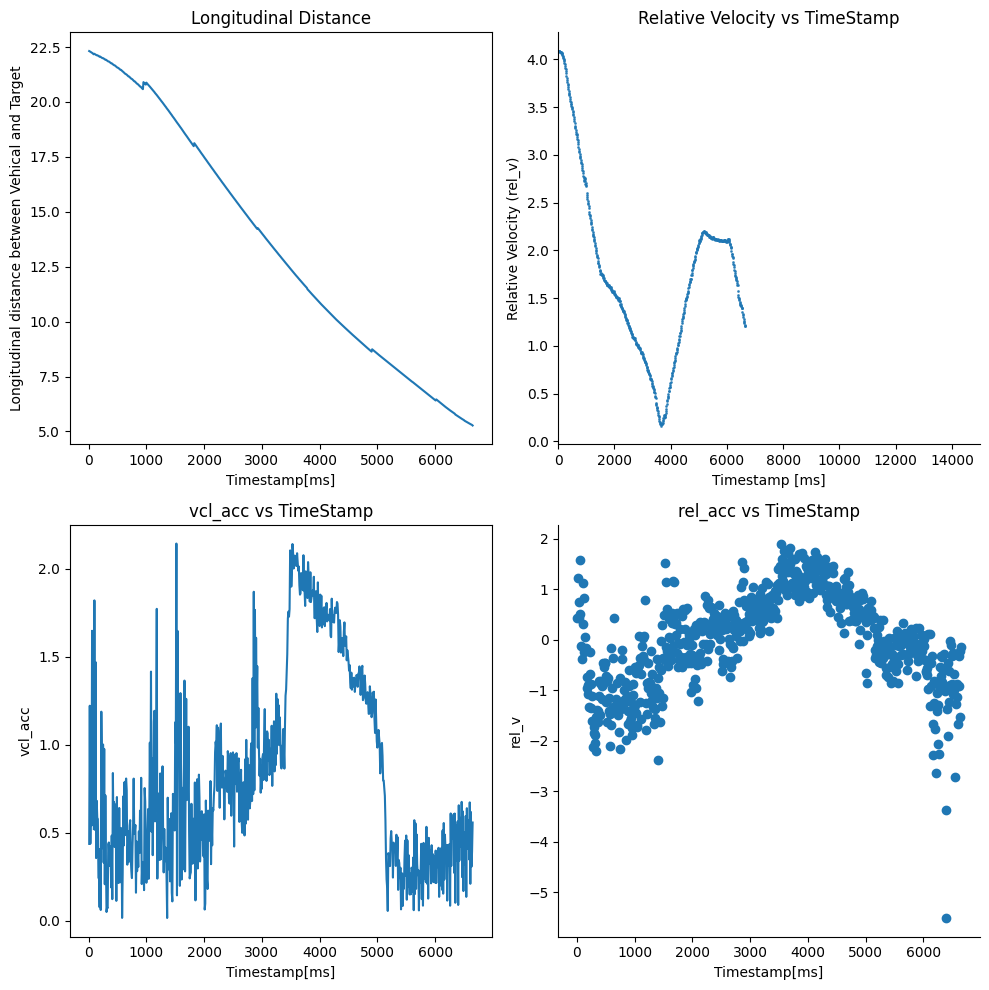

In [ ]:
df1.all_plot()

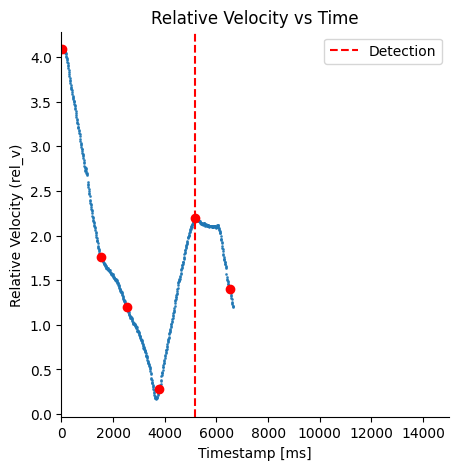

Peak Index | Peak Value | Peak Timestamp
----------------------------------------
2 | 4.086131466465179 | 30
152 | 1.7596148647595244 | 1530
252 | 1.1955983122187601 | 2530
376 | 0.27894233004161845 | 3770
516 | 2.1986058886934923 | 5170
652 | 1.401273214166926 | 6530


In [ ]:
from scipy.signal import find_peaks
x=df1.df['rel_v'].values
peaks, _ = find_peaks(x, height=0,distance=100,prominence=None)
df1.vel_plot()
plt.scatter(df1.df['Timestamp[ms]'].iloc[peaks], x[peaks], color='red')
plt.axvline(x= 5170, color='r', linestyle='--', label='Detection')
plt.legend()
plt.show()
print("Peak Index | Peak Value | Peak Timestamp")
print("-" * 40)
for idnx ,values , time_stamp in zip(peaks,x[peaks],df1.df['Timestamp[ms]'].iloc[peaks]):
  print(f"{idnx} | {values} | {time_stamp}")

In [ ]:
# df111 = vru_test("/content/VRU_NEAR_15km_29_1.trial")

In [ ]:
# x=df111.df['rel_v'].values
# peaks, _ = find_peaks(x, height=5,distance=50,prominence=None)
# df111.vel_plot()
# plt.scatter(df111.df['Timestamp[ms]'].iloc[peaks], x[peaks], color='red')
# plt.show()
# print("Peak Index | Peak Value | Peak Timestamp")
# print("-" * 40)
# for idnx ,values , time_stamp in zip(peaks,x[peaks],df111.df['Timestamp[ms]'].iloc[peaks]):
#   print(f"{idnx} | {values} | {time_stamp}")

In [ ]:
# df_test = df1.df.iloc[516:]

In [ ]:
df_test = df1.df.iloc[516:]
df_test = df_test.copy()

In [ ]:
df_test = vru_test(df_test)

Using provided DataFrame.


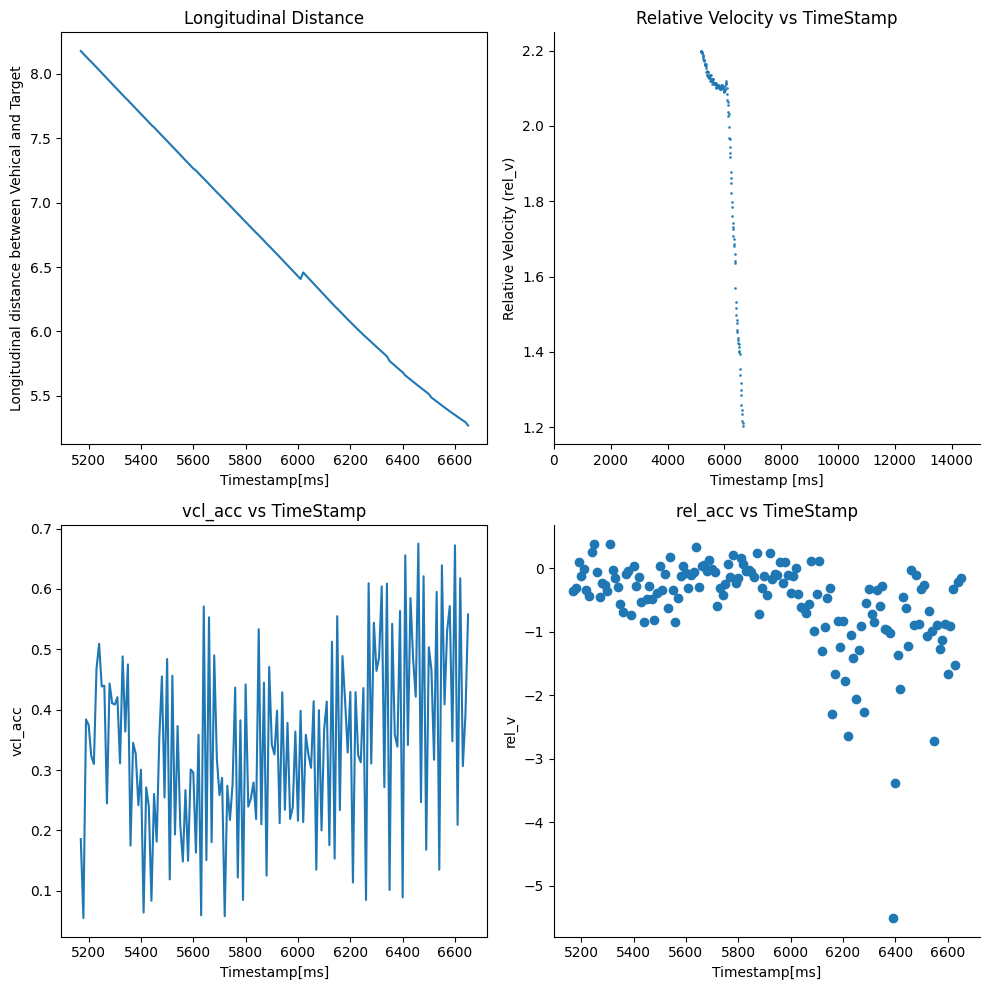

In [ ]:
df_test.all_plot()

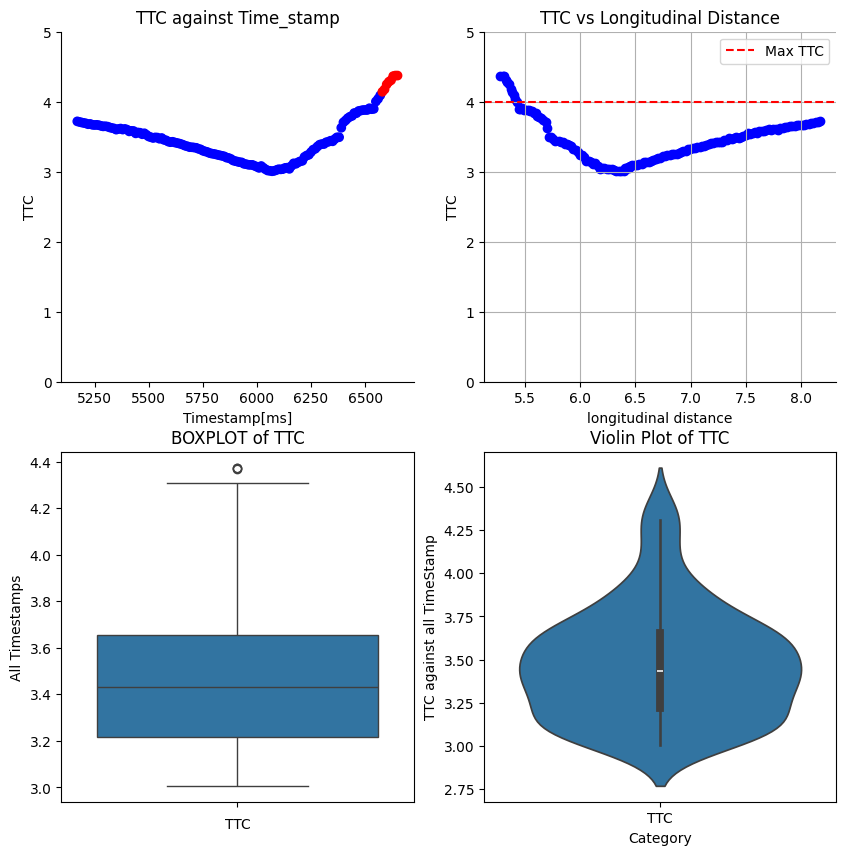

In [ ]:
df_test.ttc_plot()

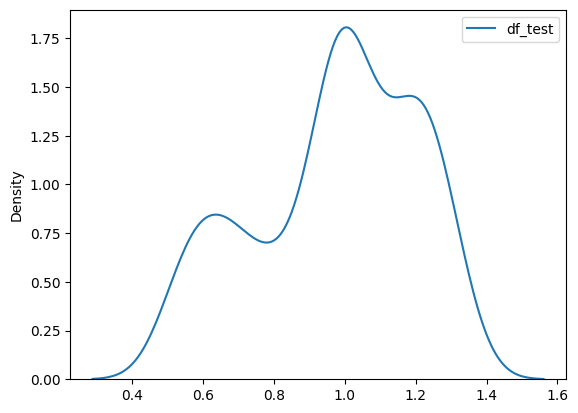

In [ ]:
sns.kdeplot(df_test.ttc_calc(), label='df_test')
# sns.kdeplot(df1.ttc_calc(), label='df1')
plt.legend()

In [ ]:
# df_test2 = df111.df.iloc[445:]
# df_test2 = df_test2.copy()
# df_test2=vru_test(df_test2)

In [ ]:
# df_test2.all_plot()

In [ ]:
# df_test2.ttc_plot()

In [ ]:
# df_test2.bd_plot()

In [ ]:
# df_test2.ttc_calc().median()

In [ ]:
df_test.ttc_plot()

NameError: name 'df_test' is not defined

In [ ]:
#  near miss rate for all the datasets
'''
Assuming that the vehicle stopped in each and every trial
'''
datasets = bd_all
standard_bd = 5
calc_mat =[]
for i, dataset in enumerate(datasets):
    # Convert dataset to a 1D NumPy array and ensure numeric conversion
    valid_data = pd.to_numeric(dataset, errors='coerce')
    valid_data = valid_data[~np.isnan(valid_data)]

    # Calculate counts
    lower_count = valid_data.median()
    if lower_count < standard_bd:
      calc_mat.append(lower_count)
# print(i)
total_count = i+1
# Calculate percentages
lower_count=len(calc_mat)
near_miss_percentage = (lower_count/ total_count) * 100 if total_count > 0 else 0

print(f"  Near miss rate: {near_miss_percentage:.2f}%")
print("-" * 20)

  Near miss rate: 66.67%
--------------------


In [ ]:
datasets = bd_all
standard_bd = 5

for i, dataset in enumerate(datasets):
    # Converting dataset to a 1D NumPy array and ensure numeric conversion
    valid_data = pd.to_numeric(dataset, errors='coerce')
    valid_data = valid_data[~np.isnan(valid_data)]

    if valid_data.empty:  # Handling empty datasets
        print(f"Dataset {i+1} is empty. Skipping.")
        continue


    lower_count = np.sum(valid_data < standard_bd)
    total_count = len(valid_data)

    # Calculate percentages
    near_miss_percentage = (lower_count / total_count) * 100 if total_count > 0 else 0

    print(f"Dataset {i+1}:")
    print(f"  Near miss rate: {near_miss_percentage:.2f}%")
    print("-" * 20)


Dataset 1:
  Near miss rate: 100.00%
--------------------
Dataset 2:
  Near miss rate: 100.00%
--------------------
Dataset 3:
  Near miss rate: 100.00%
--------------------
Dataset 4:
  Near miss rate: 100.00%
--------------------
Dataset 5:
  Near miss rate: 100.00%
--------------------
Dataset 6:
  Near miss rate: 100.00%
--------------------
Dataset 7:
  Near miss rate: 100.00%
--------------------
Dataset 8:
  Near miss rate: 100.00%
--------------------
Dataset 9:
  Near miss rate: 100.00%
--------------------
Dataset 10:
  Near miss rate: 100.00%
--------------------
Dataset 11 is empty. Skipping.
Dataset 12 is empty. Skipping.
Dataset 13 is empty. Skipping.
Dataset 14 is empty. Skipping.
Dataset 15 is empty. Skipping.


In [ ]:
# near miss using ttc
#Near miss calculation.  This code now handles empty datasets and uses median values
datasets = ttc_all
standard_bd = 2
near_miss_counts = 0

for i, dataset in enumerate(datasets):
    valid_data = pd.to_numeric(dataset, errors='coerce')
    valid_data = valid_data[~np.isnan(valid_data)]

    if valid_data.empty:
        print(f"Dataset {i+1} is empty. Skipping.")
        continue

    if valid_data.median() < standard_bd:
        near_miss_counts += 1

total_datasets = len(datasets)
near_miss_percentage = (near_miss_counts / total_datasets) * 100 if total_datasets > 0 else 0

print(f"Near miss rate: {near_miss_percentage:.2f}%")

Dataset 11 is empty. Skipping.
Dataset 12 is empty. Skipping.
Dataset 13 is empty. Skipping.
Dataset 14 is empty. Skipping.
Near miss rate: 0.00%


In [ ]:
datasets = ttc_all
standard_ttc = 4
''' Near miss rate for all the datasets'''

for i, dataset in enumerate(datasets):
    valid_data = pd.to_numeric(dataset, errors='coerce')
    valid_data = valid_data[~np.isnan(valid_data)]

    if valid_data.empty:
        print(f"Dataset {i+1} is empty. Skipping.")
        continue

    near_misses = np.sum(valid_data < standard_ttc)
    total_data_points = len(valid_data)
    near_miss_rate = (near_misses / total_data_points) * 100 if total_data_points > 0 else 0

    print(f"Dataset {i+1}:")
    print(f"  Near miss rate: {near_miss_rate:.2f}%")
    print("-" * 20)


Dataset 1:
  Near miss rate: 22.59%
--------------------
Dataset 2:
  Near miss rate: 22.59%
--------------------
Dataset 3:
  Near miss rate: 22.59%
--------------------
Dataset 4:
  Near miss rate: 22.59%
--------------------
Dataset 5:
  Near miss rate: 22.59%
--------------------
Dataset 6:
  Near miss rate: 22.59%
--------------------
Dataset 7:
  Near miss rate: 22.59%
--------------------
Dataset 8:
  Near miss rate: 22.59%
--------------------
Dataset 9:
  Near miss rate: 22.59%
--------------------
Dataset 10:
  Near miss rate: 22.59%
--------------------
Dataset 11 is empty. Skipping.
Dataset 12 is empty. Skipping.
Dataset 13 is empty. Skipping.
Dataset 14 is empty. Skipping.
